In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def perona_malik(image, num_iterations, delta_t, kappa):
    # Convert image to float32
    image = np.float32(image)

    # Loop for the number of iterations
    for _ in range(num_iterations):
        # Compute gradient of the image
        dx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
        dy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)

        # Compute gradient magnitude
        gradient_magnitude = np.sqrt(dx**2 + dy**2)

        # Compute diffusion coefficient
        diff_coefficient = 1 / (1 + (gradient_magnitude / kappa)**2)

        # Update image using diffusion equation
        image += delta_t * (cv2.Sobel(dx * diff_coefficient, cv2.CV_32F, 1, 0, ksize=3) +
                            cv2.Sobel(dy * diff_coefficient, cv2.CV_32F, 0, 1, ksize=3))

    return image

# Load image
image = cv2.imread('panda_roux.jpg', cv2.IMREAD_GRAYSCALE)

In [24]:
def linear_diffusion(image, num_iterations, delta_t, alpha):
    # Convert image to float32
    image = np.float32(image)

    # Loop for the number of iterations
    for _ in range(num_iterations):
        # Compute Laplacian of the image
        laplacian = cv2.Laplacian(image, cv2.CV_32F)

        # Update image using heat equation (linear diffusion)
        image += alpha * delta_t * laplacian

    return image

In [17]:
image_noisy = image + np.random.normal(0,30,image.shape)

Text(0.5, 1.0, 'linear diffusion')

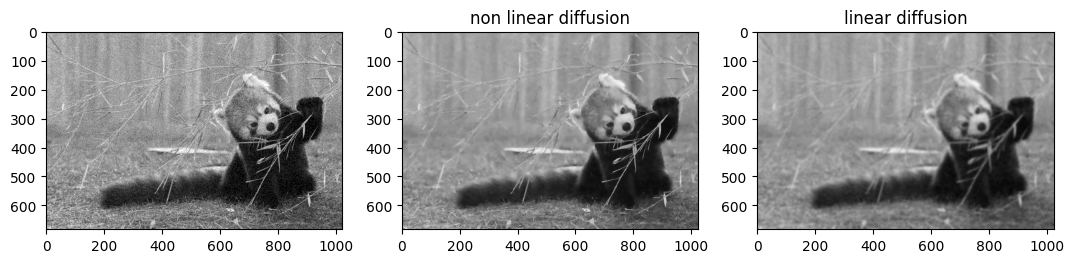

In [33]:
################## Perona Malik
# Set parameters
num_iterations = 7
delta_t = 0.1
kappa = 30

# Apply Perona-Malik model
diffusion_image = perona_malik(image_noisy, num_iterations, delta_t, kappa)

# Convert denoised image back to uint8
diffusion_image = np.uint8(np.clip(diffusion_image, 0, 255))


################## Linear model
# Set parameters
num_iterations = 50
delta_t = 0.1
alpha = 1  # Diffusion coefficient

# Apply linear diffusion model
laplace_image = linear_diffusion(image_noisy, num_iterations, delta_t, alpha)

# Convert denoised image back to uint8
laplace_image = np.uint8(np.clip(laplace_image, 0, 255))

plt.figure(figsize=(13,10))
plt.subplot(1,3,1)
plt.imshow(image_noisy, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,3,2)
plt.imshow(diffusion_image, cmap='gray', vmin=0, vmax=255)
plt.title("non linear diffusion")
plt.subplot(1,3,3)
plt.imshow(laplace_image, cmap='gray', vmin=0, vmax=255)
plt.title("linear diffusion")

In [50]:
def non_local_means_denoising(image, h, templateWindowSize, searchWindowSize):
    return cv2.fastNlMeansDenoising(image, None, h, templateWindowSize, searchWindowSize)

# Set parameters
h = 20  # Strength of filtering, higher h value more stronger filtering
templateWindowSize = 7  # Size in pixels of the window that is used to compute the weighted average for a given pixel
searchWindowSize = 21  # Size in pixels of the window that is used to compute weighted average for a given pixel

# Apply Non-Local Means denoising
image_noisy_u8 = np.uint8(np.clip(image_noisy, 0, 255))
NLM_image = non_local_means_denoising(image_noisy_u8, h, templateWindowSize, searchWindowSize)

Text(0.5, 1.0, 'non linear diffusion')

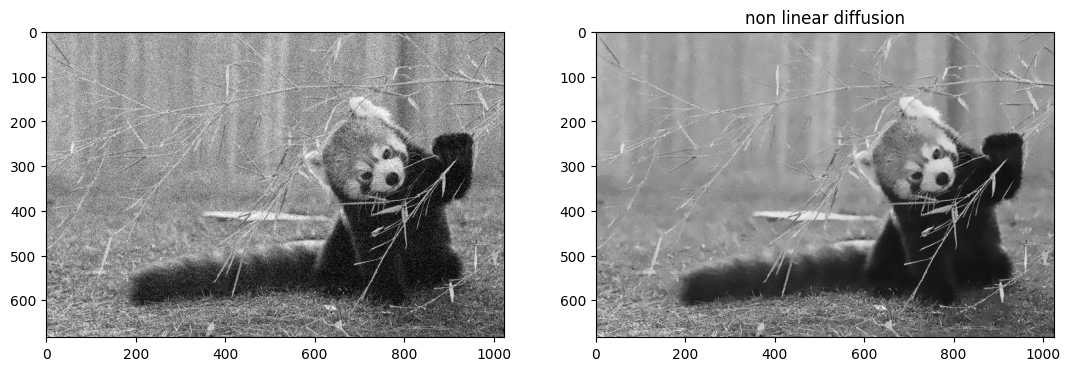

In [51]:
plt.figure(figsize=(13,10))
plt.subplot(1,2,1)
plt.imshow(image_noisy_u8, cmap='gray', vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.imshow(NLM_image, cmap='gray', vmin=0, vmax=255)
plt.title("non linear diffusion")

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [21]:
model = "models/greedy7.pt"
params = torch.load(model, map_location=torch.device('cpu'))

In [45]:
i = 7 # iteration stage; T=8, max_i = 7
rbfi = params[f'dnets.{i}.weights_rbf']
meansi = params[f'dnets.{i}.means']
stdi = params[f'dnets.{i}.std']

gaussian_rbf = lambda z, sigma: np.exp(-z**2 / (2 * sigma**2))
get_ker = lambda z, i: np.sum(np.array([rbfi[i, j] * gaussian_rbf(z - meansi[j], stdi[j]) for j in range(63)]))

x = np.linspace(-40,40,200)
get_y_i = lambda i: np.array([get_ker(xi, i) for xi in x])

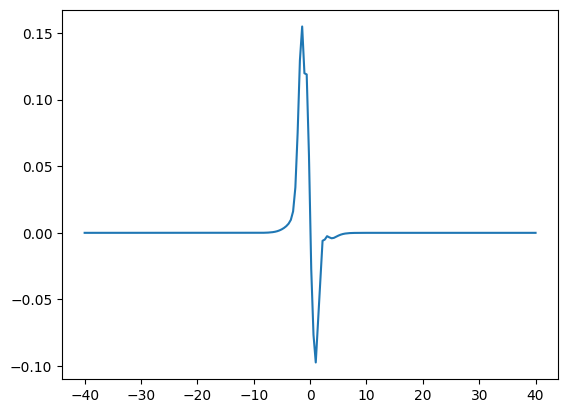

In [54]:
yi = 37
plt.plot(x, get_y_i(yi))

In [48]:
# to get rho
def integrate_phi(phi, phi_0):
  res = np.zeros(len(phi)+1)
  res[0] = phi_0
  for i in range(1, len(phi)+1):
    res[i] = res[i-1] + phi[i-1]
  return np.array(res)

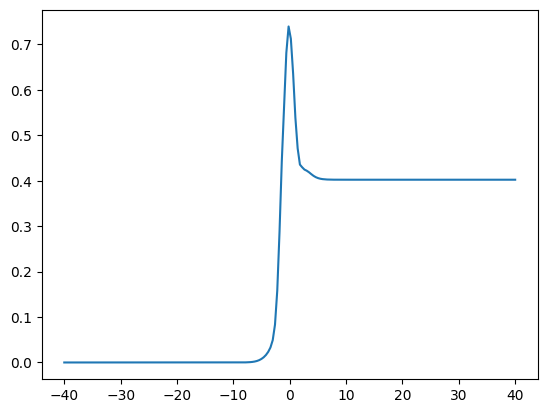

In [55]:
yi = 37
phi_0 = 0
plt.plot(x, integrate_phi(get_y_i(yi), phi_0)[1:])